In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def generate_correlated_data(autocorrelation_time, number_of_uncorrelated_measurements, scale_randn=0.0):
    τ = autocorrelation_time
    _N = number_of_uncorrelated_measurements
    ΔMC_data = 1.0/(τ - 1)
    N = _N*τ
    _data = np.random.rand(_N)
    data = np.zeros(N)
    for i in range(_N):
        if np.random.rand() < 0.5:
            for j in range(τ):
                data[i*τ + j] = _data[i] - 0.5 + ΔMC_data*j*(np.random.randn()*scale_randn + 1.0)
        else:
            for j in range(τ):
                data[i*τ + j] = _data[i] + 0.5 - ΔMC_data*j*(np.random.randn()*scale_randn + 1.0)
    return data

In [56]:
def autocorrelation_function(time,scale,autocorrelation_time):
    return scale*np.exp(-time/autocorrelation_time)

def generate_correlated_data2(autocorrelation_time, number_of_measurements, scale_randn=0.0):
    τ = autocorrelation_time
    N = number_of_measurements
    _data = np.random.rand(N)
    data = np.zeros(N)
    for i in range(N):
        for j in range(i+1):
            data[i] += _data[j]*autocorrelation_function(i-j,1.0,autocorrelation_time)
    return data

In [57]:
def generate_correlated_data3(autocorrelation_time, number_of_measurements, scale_randn=0.0):
    τ = autocorrelation_time
    N = number_of_measurements
    _data = np.random.rand(N)
    data = np.zeros(N)
    for i in range(N):
        data[i] = (_data[:i]*autocorrelation_function(np.arange(i),1.0,autocorrelation_time)[::-1]).sum()
    return data

In [58]:
# autocorrelation_time = 30
# number_of_uncorrelated_measurements = 10000
# data_correlated = generate_correlated_data(autocorrelation_time, number_of_uncorrelated_measurements)
# MC_steps = np.arange(data_correlated.shape[0])

In [59]:
# autocorrelation_time = 60
# number_of_measurements = 100000
# data_correlated = generate_correlated_data3(autocorrelation_time, number_of_measurements)
# MC_steps = np.arange(data_correlated.shape[0])

In [60]:
# Load data
data_correlated = np.loadtxt("1D_20_20_10_3.300000_1.000000_4.000000_1_K_1968_square.dat")[2000:]
MC_steps = np.arange(data_correlated.shape[0])
data_correlated

array([-28.75, -28.75, -28.75, ..., -22.5 , -22.5 , -22.5 ])

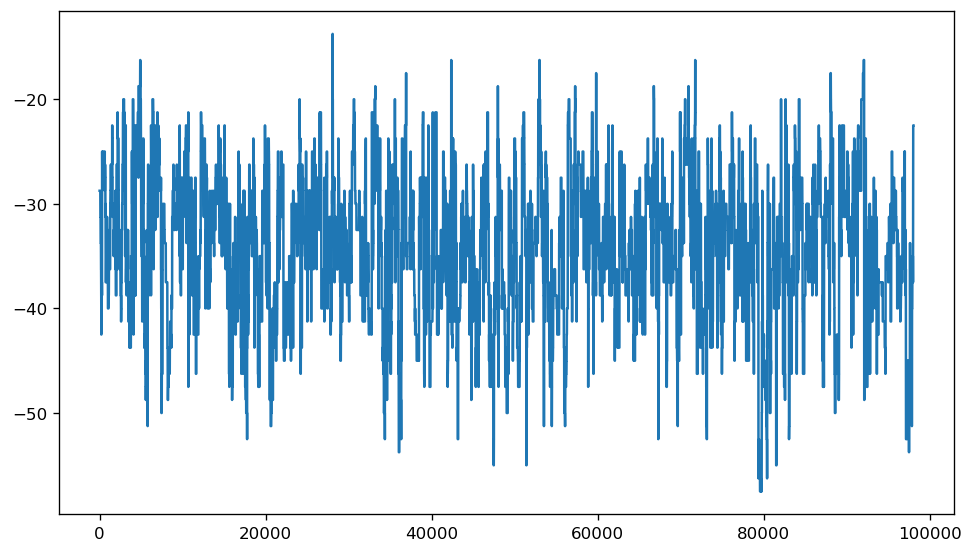

In [61]:
fig, ax = plt.subplots(figsize=(8,4.5), dpi=120, constrained_layout=True)
ax.plot(MC_steps,data_correlated)

(0.0, 1000.0)

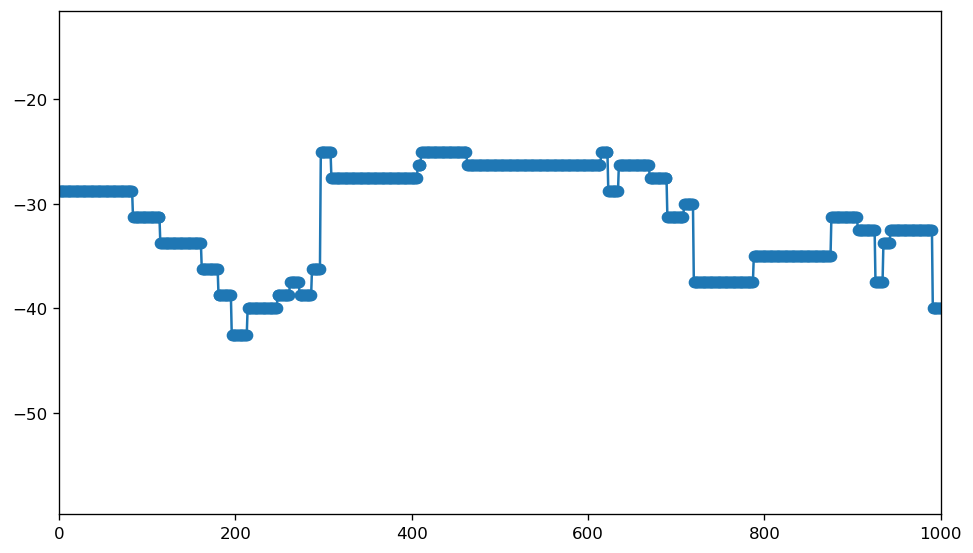

In [62]:
fig, ax = plt.subplots(figsize=(8,4.5), dpi=120, constrained_layout=True)
ax.plot(MC_steps,data_correlated,marker="o")
ax.set_xlim(0,1000)

$$ C(t) = \frac{\frac{1}{N-t}\sum_{i=1}^{N-t}{X_{i}X_{i+t}-{\left\langle{X}\right\rangle^2}}}{\left\langle{X^2}\right\rangle-{\left\langle{X}\right\rangle^2}} \sim e^{\frac{t}{\tau_\mathrm{exp}}} $$

In [63]:
def autocorrelation(data):
    N = data.shape[0]
    _autocorrelation = np.zeros(N)
    for Δt in range(N-1):
        denom = np.mean(data[:N - Δt]**2) - np.mean(data[:N - Δt])**2 #Variance at t0
        num = np.mean(data[:N - Δt]*data[Δt:]) - np.mean(data[:N - Δt])*np.mean(data[Δt:])
        _autocorrelation[Δt] = num/denom
    return _autocorrelation

In [64]:
_autocorrelation = autocorrelation(data_correlated)

# Eliminate nans (there's usually just a few)
_autocorrelation = np.ma.masked_array(_autocorrelation, ~np.isfinite(_autocorrelation)).filled(0)

time_separation = np.arange(_autocorrelation.shape[0])

<ipython-input-63-7e6e5bbab7af>:7: RuntimeWarning: invalid value encountered in double_scalars
  _autocorrelation[Δt] = num/denom
<ipython-input-63-7e6e5bbab7af>:7: RuntimeWarning: divide by zero encountered in double_scalars
  _autocorrelation[Δt] = num/denom


In [65]:
np.size(_autocorrelation)

98000

In [66]:
np.sum(np.isfinite(_autocorrelation))

98000

In [67]:
from scipy.optimize import curve_fit

In [68]:
def autocorrelation_function(time,scale,autocorrelation_time):
    return scale*np.exp(-time/autocorrelation_time)

In [69]:
popt, perr = curve_fit(autocorrelation_function, time_separation, _autocorrelation)

$$ \tau_\mathrm{int}=\sum_k \frac{C(k)}{C(0)}$$

In [70]:
def integrated_autocorrelation_time(data):
    data_mean_squared = np.mean(data)**2
    variance = np.mean(data**2) - data_mean_squared
    τ_int_auto = 0.0
    N = data.shape[0]
    for Δt in range(N):
        τ_int_auto += np.mean(data[:N - Δt]*data[Δt:]) - data_mean_squared
    return τ_int_auto/variance

In [71]:
autocorrelation_time_int = integrated_autocorrelation_time(data_correlated)

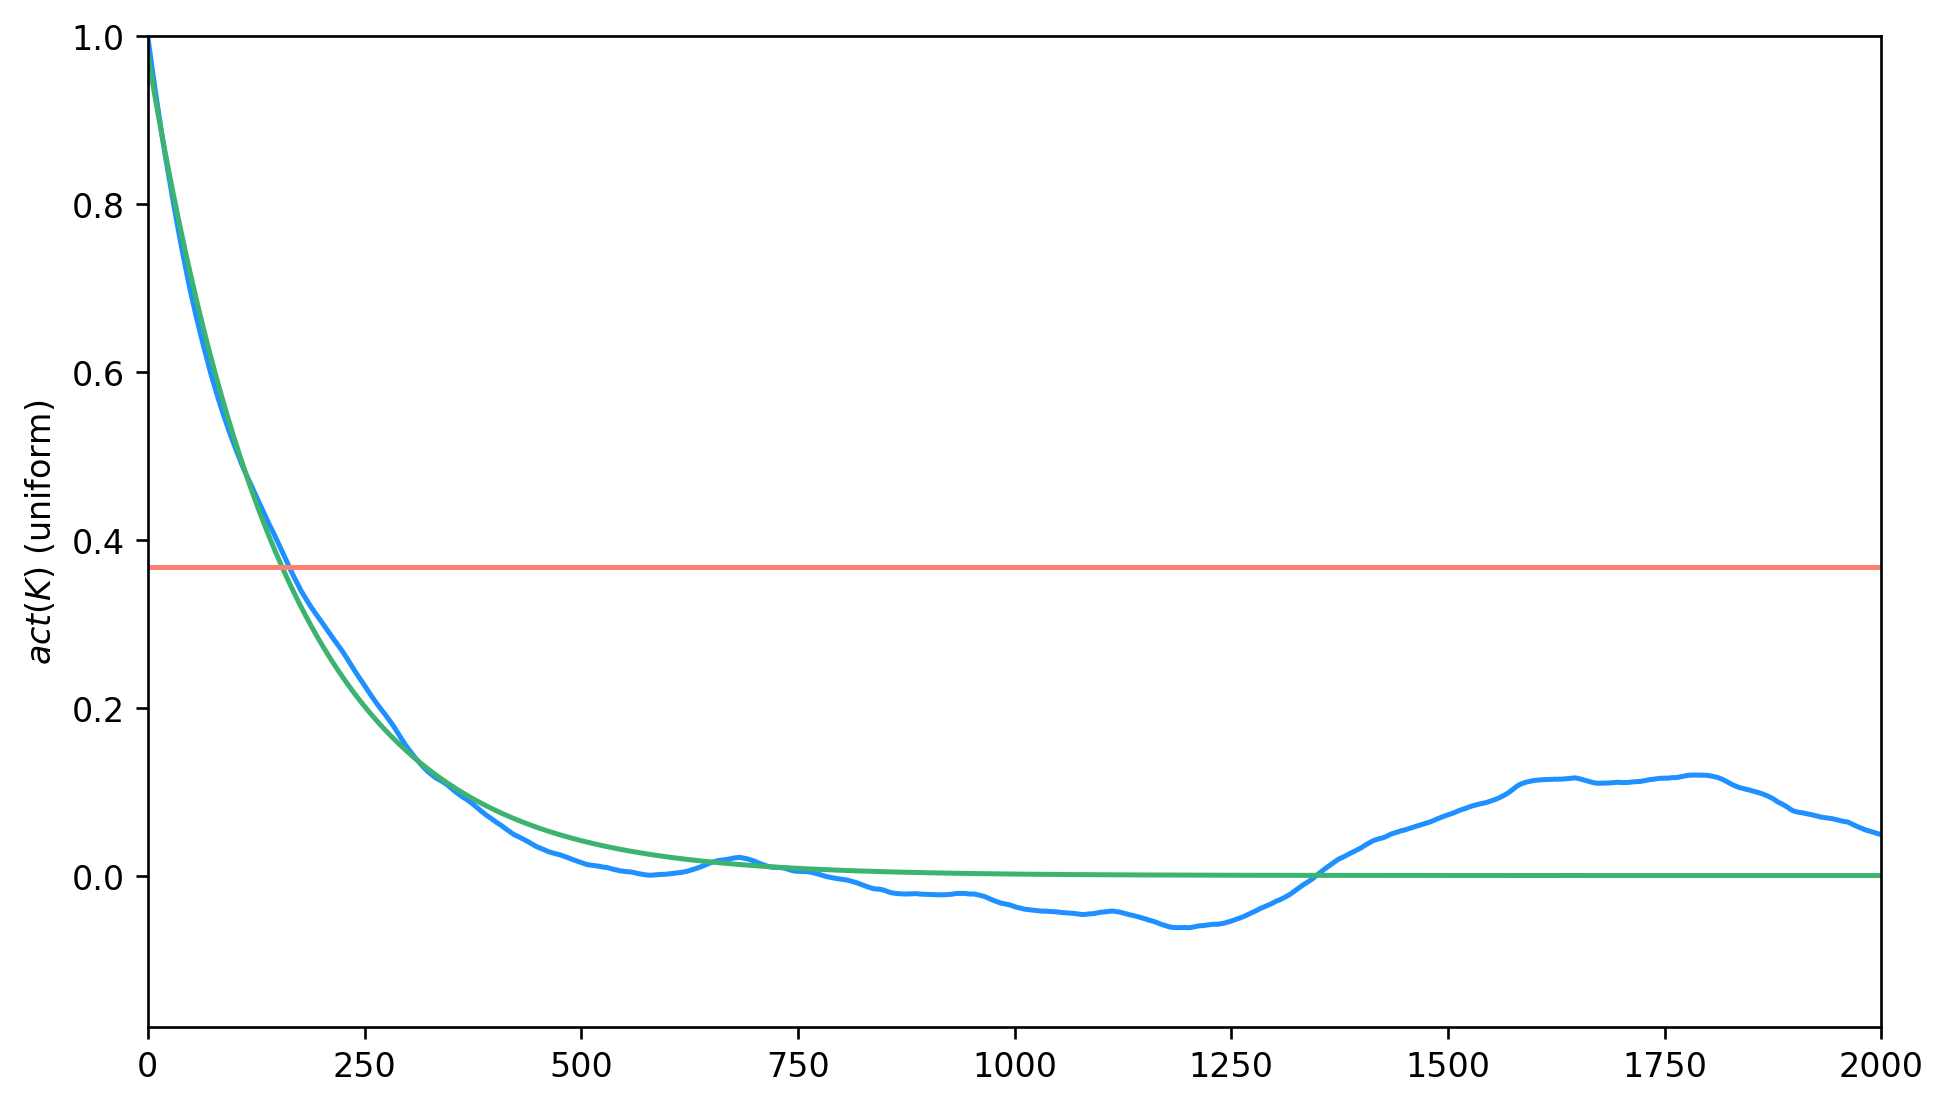

In [74]:
fig,ax = plt.subplots(figsize=(8,4.5), dpi=240, constrained_layout=True)
ax.plot(time_separation, _autocorrelation,color='dodgerblue')
ax.plot(time_separation, autocorrelation_function(time_separation,*popt),color='mediumseagreen')
#ax.plot(time_separation, autocorrelation_function(time_separation, 1.0, autocorrelation_time_int))
ax.axhline(1/np.exp(1.0),color='salmon')
# ax.axvline(autocorrelation_time,linestyle=":",color='k')
ax.set_xlim((0,2000))
ax.set_ylim(-0.18,1)
# ax.set_yscale('log')
ax.set_ylabel(r'$act(K)$ (uniform)')
plt.savefig("act_kinetic_uniform.pdf",dpi=300)

In [52]:
print("τ_auto: {}".format(popt[1]))
print("4τ_auto: {}".format(4*popt[1]))
print("τ_auto_int: {}".format(autocorrelation_time_int))
# print("τ_exact: {}".format(autocorrelation_time))

τ_auto: 158.34734062146927
4τ_auto: 633.3893624858771
τ_auto_int: -15530.453542866362
